* 환경 : Windows 10 이상, python 3.9 ( 아마 python 3.7 이상이면 동작할 거에요. ) 
* PC에 엔비디아 그래픽카드가 없다면 Catboost 실행이 안될 거에요. 그땐, Catboost 파라미터 중 task_tpye='GPU'를 지워주시면 돼요.
* GPU를 사용하지 않으면, PC의 CPU 자원을 모두 활용하기 때문에, PC가 멈출 수 있어요(렉이 심해지거나).
* 그럴 때는 thread_count=(모델이 활용하길 바라는 CPU 개수) ex) thread_count=5 (기본값은 thread_count=-1 로, -1은 모두 사용이란 의미입니다.)


In [ ]:
# # 라이브러리 설치이니 아래 코드들을 주석을 지운 뒤 실행시켜 주시면 돼요. (기존에 설치되어 있는 패키지는 스킵하고 설치됩니다.)
# # 주석을 한번에 지우는 방법 ----> 지우고 싶은 줄들을 드래그 하고, ctrl + '/' 를 누르면 한번에 지워져요.

# !pip install pandas
# !pip install numpy
# !pip install scikit-learn
# !pip install imblearn
# !pip install matplotlib
# !pip install seaborn
# !pip install missingno
# !pip install catboost
# !pip install optuna

In [1]:
# Ignore Warning message
import warnings
warnings.filterwarnings('ignore')

# Random seed fix
import os
import random

# progress bar in repeated code
from tqdm import tqdm
import pandas as pd
import numpy as np

# Imputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Data Scaling
from imblearn.over_sampling import BorderlineSMOTE, ADASYN, RandomOverSampler
from imblearn.combine import SMOTEENN, SMOTETomek

# Visualization
import matplotlib.pyplot as plt
from pylab import rcParams
plt.style.use('fivethirtyeight')
plt.rc("font", family="Malgun Gothic")
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

import seaborn as sns
import missingno as msno

# Validation
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split

# Scoring
from sklearn.metrics import f1_score

# Model & AutoML
import catboost
import optuna

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(37) # Seed 고정

In [3]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
subm = pd.read_csv('./sample_submission.csv')

In [4]:
train.head()

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TRAIN_000,1,0.533433,2022-06-13 5:14,T050304,A_31,NaN,NaN,NaN,NaN,...,39.34,40.89,32.56,34.09,77.77,NaN,NaN,NaN,NaN,NaN
1,TRAIN_001,2,0.541819,2022-06-13 5:22,T050307,A_31,NaN,NaN,NaN,NaN,...,38.89,42.82,43.92,35.34,72.55,NaN,NaN,NaN,NaN,NaN
2,TRAIN_002,1,0.531267,2022-06-13 5:30,T050304,A_31,NaN,NaN,NaN,NaN,...,39.19,36.65,42.47,36.53,78.35,NaN,NaN,NaN,NaN,NaN
3,TRAIN_003,2,0.537325,2022-06-13 5:39,T050307,A_31,NaN,NaN,NaN,NaN,...,37.74,39.17,52.17,30.58,71.78,NaN,NaN,NaN,NaN,NaN
4,TRAIN_004,1,0.531590,2022-06-13 5:47,T050304,A_31,NaN,NaN,NaN,NaN,...,38.70,41.89,46.93,33.09,76.97,NaN,NaN,NaN,NaN,NaN


In [5]:
train['PRODUCT_CODE'] = train['PRODUCT_CODE'].astype('category')
train['LINE'] = train['LINE'].astype('category')

test['PRODUCT_CODE'] = test['PRODUCT_CODE'].astype('category')
test['LINE'] = test['LINE'].astype('category')

In [6]:
# train에서 열의 유일한 값이 nan이거나 모두 같은 값인 경우 해당 열을 제외
def remove_col(train_df, test_df):
    for x in train_df.columns[6:]:
        if train_df[x].nunique()==0 or (train_df[x].nunique()==1 and len(train_df[x].unique())==1): # nan 이거나 모두 같은 값인 경우
            train_df.drop(columns=[x], inplace=True)
            test_df.drop(columns=[x], inplace=True)
    return train_df, test_df

In [7]:
train, test = remove_col(train, test)

In [8]:
train.drop(columns=['PRODUCT_ID', 'TIMESTAMP', 'Y_Quality'], inplace=True)

test = test[train.columns[1:]]

In [9]:
train_x, train_y = train.drop(columns=['Y_Class']), train['Y_Class']

In [10]:
train_x.head()

,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,...,X_2862,X_2863,X_2864,X_2865,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871
0,T050304,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,189.0,383.0,368.296296,353.0,39.34,40.89,32.56,34.09,77.77,NaN
1,T050307,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,185.6,383.0,367.735849,353.0,38.89,42.82,43.92,35.34,72.55,NaN
2,T050304,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,165.5,383.0,367.320755,353.0,39.19,36.65,42.47,36.53,78.35,NaN
3,T050307,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,165.8,384.0,369.188679,353.0,37.74,39.17,52.17,30.58,71.78,NaN
4,T050304,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,182.6,383.0,367.351852,352.0,38.70,41.89,46.93,33.09,76.97,NaN


### catboost cv

In [13]:
train_y.value_counts()

1    407
2    103
0     88
Name: Y_Class, dtype: int64

* RepeatedStratifiedKFold를 활용하면 추후 test set의 결과를 추정할 수 있다.
* rskfold를 활용한 결과를 개선해나가는 것이 목표

In [15]:
rskfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)

f1_list = []
for fold, (train_index, val_index) in enumerate(tqdm(rskfold.split(train_x, train_y))):
    x_trn, x_val, y_trn, y_val = train_x.loc[train_index], train_x.loc[val_index], train_y.loc[train_index], train_y.loc[val_index]

    clf = catboost.CatBoostClassifier(verbose=0, task_type='GPU') # cpu -> thread_count=5
    clf.fit(x_trn, y_trn, early_stopping_rounds=100, cat_features=['PRODUCT_CODE', 'LINE'])
    f1_list.append(f1_score(clf.predict(x_val), y_val, average='macro'))
    
print(f'{min(f1_list)} ~ {max(f1_list)}')
print('mean :', np.mean(f1_list))

15it [05:47, 23.17s/it]

0.5762430939226518 ~ 0.7513497039359108
mean : 0.6719199919417582


### Feature importance

* Permutation Importance를 사용하지 않은 이유는, train_x를 학습한 모델에서의 영향력을 보여주는 지표이기 때문
* train에서 영향력이 큰 컬럼일지라도, test에서 같은 컬럼이 value가 nan인 경우만 있을 수 있기 때문에 함부로 제거해서는 안된다.


* Feature Importance는 학습된 모델에서 주로 사용된 컬럼들을 나타내기 때문에, 학습에 도움이 되지 않은 컬럼을 지워준다고 해도
* test predict에 영향력이 적다. 또한, 줄어든 컬럼으로 학습 방식이 바뀌고, overfit을 완화하여 더 나은 결과를 유도할 수 있다.

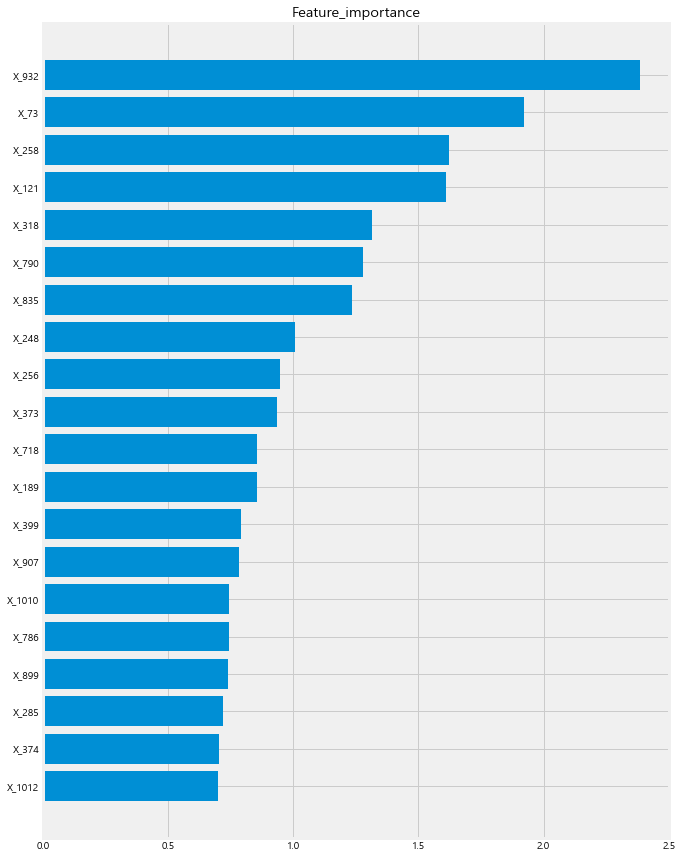

In [11]:
clf = catboost.CatBoostClassifier(verbose=0, task_type='GPU')
clf.fit(train_x, train_y, early_stopping_rounds=100, cat_features=['PRODUCT_CODE', 'LINE'])

feat = clf.feature_importances_
feature_imp = pd.Series(feat, index=train_x.columns).sort_values(ascending=False)[:20].sort_values()

plt.rcParams["figure.figsize"] = (10, 15)
plt.barh(feature_imp.index, feature_imp)
plt.title('Feature_importance')
plt.show()

In [12]:
# feature_importance > 0 인 컬럼만 선택
tmp = pd.Series(feat[feat > 0], index=train_x.columns[feat > 0]).sort_values(ascending=False)[:]
train_x = train_x[tmp.index]
test = test[train_x.columns]
train_x

,X_932,X_73,X_258,X_121,X_318,X_790,X_835,X_248,X_256,X_373,...,X_1565,X_1922,X_1806,X_1894,X_931,X_1832,X_1762,X_981,X_2865,X_564
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.000000,2.702761,0.000000,NaN,1.414252,0.036773,13.8,353.0,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.453569,0.228109,0.072995,NaN,1.363817,0.062509,13.8,353.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.000000,2.532455,0.000000,NaN,1.418331,0.030454,13.8,353.0,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.000000,0.238499,0.000000,NaN,1.416721,0.064830,13.7,353.0,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.000000,2.514551,0.000000,NaN,1.418331,0.029483,13.8,352.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,13.351613,10.09,NaN,34.1,NaN,737.0,9.096774,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,13.6,NaN,NaN,NaN,NaN,15.0
594,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.000000,1.743375,0.000000,NaN,1.410926,0.019844,13.8,353.0,NaN
595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.000000,1.789826,0.000000,NaN,1.422233,0.027558,13.8,352.0,NaN
596,13.406667,10.22,NaN,33.7,NaN,739.0,9.533333,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,13.6,NaN,NaN,NaN,NaN,15.0


In [18]:
rskfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)

f1_list = []
class_rate = []
for fold, (train_index, val_index) in enumerate(tqdm(rskfold.split(train_x, train_y))):
    x_trn, x_val, y_trn, y_val = train_x.loc[train_index], train_x.loc[val_index], train_y.loc[train_index], train_y.loc[val_index]

    clf = catboost.CatBoostClassifier(verbose=0, task_type="GPU") # cpu -> thread_count=5, gpu -> task_type="GPU"
    clf.fit(x_trn, y_trn, early_stopping_rounds=100)
    f1_list.append(f1_score(clf.predict(x_val), y_val, average='macro'))
    class_rate.append(np.array([len(y_val[y_val==0]), len(y_val[y_val==1]), len(y_val[y_val==1])]) / len(y_val))
    
print(f'{min(f1_list)} ~ {max(f1_list)}')
print('mean :', np.mean(f1_list))

15it [03:33, 14.21s/it]

0.5957223001402524 ~ 0.7854452515469464
mean : 0.6866430811854247


### 결측치 대체

#### Missingno

<AxesSubplot:>

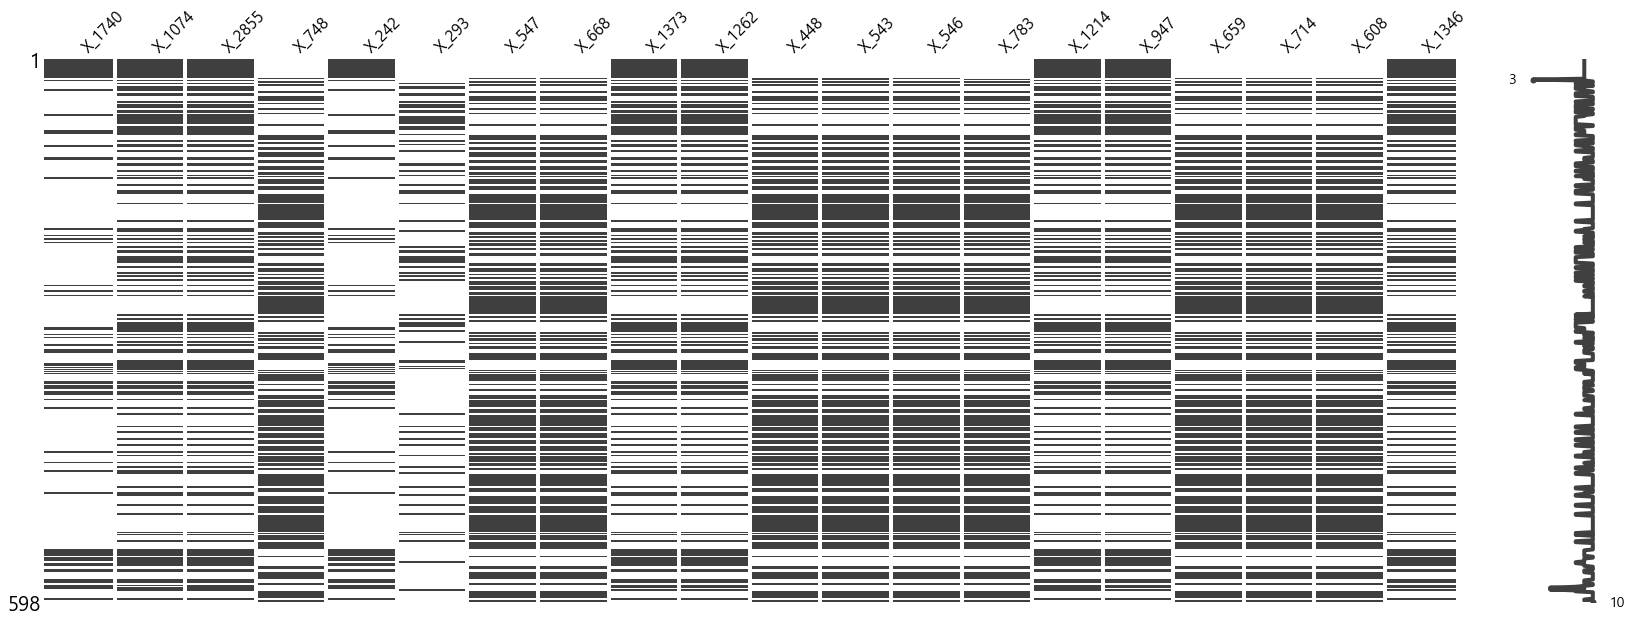

In [19]:
# 20개의 열만 뽑아 확인해 보았는데도 결측치가 굉장히 많다.
msno.matrix(train_x[train_x.columns[130:150]])

#### fillna(0)

* Catboost는 nan을 'string' 타입으로 치환하여 학습을 진행할 수 있다. 따라서 fillna(0)와 유사한 성능이 나타난다.
* MiceImputer, SimpleImputer 등 다양한 방법들을 활용해 보았지만, 성능향상에 도움이 되지 않았다.

In [13]:
train_x.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [21]:
rskfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)
clf = catboost.CatBoostClassifier(verbose=0, task_type="GPU") # cpu -> thread_count=5

f1_list = []
for fold, (train_index, val_index) in enumerate(tqdm(rskfold.split(train_x, train_y))):
    x_trn, x_val, y_trn, y_val = train_x.loc[train_index], train_x.loc[val_index], train_y.loc[train_index], train_y.loc[val_index]

    clf.fit(x_trn, y_trn, early_stopping_rounds=100)
    f1_list.append(f1_score(clf.predict(x_val), y_val, average='macro'))
    
print(f'{min(f1_list)} ~ {max(f1_list)}')
print('mean :', np.mean(f1_list))

15it [03:44, 14.95s/it]

0.5963383838383839 ~ 0.7701587301587303
mean : 0.6862455387951153


### Data Scaling

* 데이터의 적은 수를 극복하고자 오버샘플링을 통한 성능향상을 기대했지만 오히려 성능이 나빠졌다.
* 이는 컬럼 수가 너무 많고, 결측치를 0으로 바꾸었기 때문.
* 다른 컬럼과의 관계를 이용하지 않고, 단순히 데이터를 늘리는 랜덤오버샘플링도 성능이 향상되진 않았다.

In [22]:
def Randomoversampler(train_x_df, train_y_df):
    x_ros, y_ros = RandomOverSampler().fit_resample(train_x_df, train_y_df)
    return x_ros, y_ros

In [23]:
def SMOTE_Tomek(train_x_df, train_y_df):
    x_smoteenn, y_smoteenn = SMOTETomek().fit_resample(train_x_df, train_y_df)
    return x_smoteenn, y_smoteenn

In [24]:
def SMOTE_ENN(train_x_df, train_y_df):
    x_smoteenn, y_smoteenn = SMOTEENN().fit_resample(train_x_df, train_y_df)
    return x_smoteenn, y_smoteenn

In [25]:
def ADASYN_(train_x_df, train_y_df):
    x_adasyn, y_adasyn = ADASYN(sampling_strategy='minority').fit_resample(train_x_df, train_y_df)
    return x_adasyn, y_adasyn

In [26]:
def Borderline_SMOTE(train_x_df, train_y_df):
    x_b_smote, y_b_smote = BorderlineSMOTE().fit_resample(train_x_df, train_y_df)
    return x_b_smote, y_b_smote

#### RandomOverSampling

In [27]:
rskfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)

f1_list = []
for fold, (train_index, val_index) in enumerate(tqdm(rskfold.split(train_x, train_y))):
    x_trn, x_val, y_trn, y_val = train_x.loc[train_index], train_x.loc[val_index], train_y.loc[train_index], train_y.loc[val_index]
    x_trn, y_trn = Randomoversampler(x_trn, y_trn)
    
    clf = catboost.CatBoostClassifier(verbose=0, task_type="GPU") # cpu -> thread_count=5
    clf.fit(x_trn, y_trn, early_stopping_rounds=100)
    f1_list.append(f1_score(clf.predict(x_val), y_val, average='macro'))
    
print(f'{min(f1_list)} ~ {max(f1_list)}')
print('mean :', np.mean(f1_list))

15it [04:00, 16.06s/it]

0.5352011494252874 ~ 0.7306722689075631
mean : 0.6521097147005214


* SMOTE ENN : 0.5908302192371786
* SMOTE Tomek : 0.641878141042391
* ADASYN : 0.6551906565507466
* Borderline SMOTE : 0.6455799000034791

### OPTUNA

* repeatedcv는 시간이 매우 오래 걸려서 여기서는 train_test_split을 활용해서 진행했다.

#### 하이퍼 파라미터 튜닝 전 f1 score

In [14]:
x_trn, x_val, y_trn, y_val = train_test_split(train_x, train_y, test_size=0.3)

In [15]:
clf = catboost.CatBoostClassifier(verbose=0, task_type="GPU") # cpu -> thread_count=5
clf.fit(x_trn, y_trn, early_stopping_rounds=100)

f1_score(clf.predict(x_val), y_val, average='macro')

0.6458906662080036

#### OPTUNA

In [16]:
def cb_objective(trial):

    params = {
            'iterations':trial.suggest_int("iterations", 500, 3000),
            'objective':trial.suggest_categorical('objective',['MultiClass']),
            'bootstrap_type':trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli']),
            'od_wait':trial.suggest_int('od_wait', 500, 1000),
            'learning_rate' : trial.suggest_uniform('learning_rate',0.01,1),
            'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
            'random_strength': trial.suggest_uniform('random_strength',20,50),
            'depth': trial.suggest_int('depth',1,15),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,20),
            'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
            'verbose': False,
            "eval_metric":'TotalF1',
            #"cat_features" : ['PRODUCT_CODE', 'LINE'],
            "one_hot_max_size": trial.suggest_int("one_hot_max_size",1,5),
            #'task_type' : 'GPU',
            'thread_count' : 4
        }

    if params['bootstrap_type'] == 'Bayesian':
        params['bagging_temperature'] = trial.suggest_float('bagging_temperature', 0, 10)
    elif params['bootstrap_type'] == 'Bernoulli':
        params['subsample'] = trial.suggest_float('subsample', 0.1, 1)
    
    clf = catboost.CatBoostClassifier(**params)
    clf.fit(x_trn, y_trn, early_stopping_rounds=100)

    return f1_score(clf.predict(x_val), y_val, average='macro')

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(cb_objective, n_trials=20, show_progress_bar=True)

[I 2023-02-20 19:59:05,890] A new study created in memory with name: no-name-d7d2e060-a990-4500-b7bb-ab0cfc4c71c4


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2023-02-20 20:01:02,469] Trial 0 finished with value: 0.5252852818979942 and parameters: {'iterations': 1242, 'objective': 'MultiClass', 'bootstrap_type': 'Bernoulli', 'od_wait': 604, 'learning_rate': 0.1402977267571144, 'reg_lambda': 73.60151807064516, 'random_strength': 47.918345029350434, 'depth': 6, 'min_data_in_leaf': 15, 'leaf_estimation_iterations': 6, 'one_hot_max_size': 4, 'subsample': 0.5304090061058219}. Best is trial 0 with value: 0.5252852818979942.


In [ ]:
fig = optuna.visualization.plot_parallel_coordinate(study, params=["x", "y"])
fig.show()

In [86]:
print(study.best_trial, end='\n\n')
print(study.best_params)

{'iterations': 1337,
 'objective': 'MultiClass',
 'bootstrap_type': 'Bayesian',
 'od_wait': 552,
 'learning_rate': 0.6128454724915484,
 'reg_lambda': 77.08090755141544,
 'random_strength': 43.1413895840195,
 'depth': 3,
 'min_data_in_leaf': 20,
 'leaf_estimation_iterations': 2,
 'one_hot_max_size': 1,
 'bagging_temperature': 0.06040383536784377}

#### threshold(임계값) 변경

In [ ]:
def cb_objective(trial):

    params = {
            'iterations':trial.suggest_int("iterations", 500, 3000),
            'objective':trial.suggest_categorical('objective',['MultiClass']),
            'bootstrap_type':trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli']),
            'od_wait':trial.suggest_int('od_wait', 500, 1000),
            'learning_rate' : trial.suggest_uniform('learning_rate',0.01,1),
            'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
            'random_strength': trial.suggest_uniform('random_strength',20,50),
            'depth': trial.suggest_int('depth',1,15),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,20),
            'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
            'verbose': False,
            "eval_metric":'TotalF1',
            #"cat_features" : ['PRODUCT_CODE', 'LINE'],
            "one_hot_max_size": trial.suggest_int("one_hot_max_size",1,5),
            'task_type' : 'GPU',
        }

    if params['bootstrap_type'] == 'Bayesian':
        params['bagging_temperature'] = trial.suggest_float('bagging_temperature', 0, 10)
    elif params['bootstrap_type'] == 'Bernoulli':
        params['subsample'] = trial.suggest_float('subsample', 0.1, 1)
    
    clf = catboost.CatBoostClassifier(**params)
    clf.fit(x_trn, y_trn, early_stopping_rounds=100)
        
    # Y_Class = 1 이라고 예측했지만, 그 확률이 0.45 미만인 경우, 다른 Y_Class로 변경하도록 했다.
    pred = []
    for proba in clf.predict_proba(x_val):
        if list(proba).index(max(proba)) == 1 and max(proba) <= 0.45:
            if proba[0] > proba[2]: 
                pred.append(0)
            elif proba[0] < proba[2]:
                pred.append(2)
            else:
                pred.append(1)
        else:
            pred.append(list(proba).index(max(proba)))

    return f1_score(pred, y_val, average='macro')

In [70]:
clf = catboost.CatBoostClassifier(**study.best_params, verbose=0).fit(train_x, train_y)
pred = clf.predict(test)
subm['Y_Class'] = pred

In [80]:
subm.Y_Class.value_counts()

1    264
0     39
2      7
Name: Y_Class, dtype: int64

In [81]:
subm.to_csv('./submission_36_feat_del.csv', index=False)